In [1]:
import os

import numpy as np
from netCDF4 import Dataset
import pandas as pd

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


pd.set_option('display.max_rows', None)

In [2]:
hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/2023061012/hofx/"
#hofx_file = "hofx_adpsfc_qonly_allwithinwindow.nc"
#hofx_file2 = "hofx_adpsfc_qonly_temporalthinning.nc"
hofx_file = "hofx_adpsfc_airTemperature_187.nc"
hofx_file2 = "hofx_adpsfc_airTemperature_187_filtered.nc"

group = "ObsValue"
varname = "airTemperature"
#colormap="cool"
colormap="coolwarm"

In [3]:
def read_hofx_file(file_dir, filename, groupname, varname, flag):
    # Load the NetCDF file
    nc_file = os.path.join(file_dir, filename)
    nc_data = Dataset(nc_file, "r")

    # Extract latitude, longitude, and values
    flags = nc_data.groups["EffectiveQC0"].variables[varname][:]
    lats = nc_data.groups["MetaData"].variables["latitude"][:][flags == flag]
    lons = nc_data.groups["MetaData"].variables["longitude"][:][flags == flag]
    press = nc_data.groups["MetaData"].variables["pressure"][:][flags == flag]
    #values = nc_data.groups["MetaData"].variables["timeOffset"][:][flags == flag]
    values = nc_data.groups[groupname].variables[varname][:][flags == flag]
    if varname in ["specificHumidity", ]:
        values = values * 1000

    return lats, lons, press, values

In [4]:
def find_duplicates(lats, lons, press, values):

    data = np.column_stack((lats, lons, press, values))
    df = pd.DataFrame(data, columns=['lats', 'lons', 'press', 'values'])
    #print(df)

    # Group by 'lats' and 'lons' and aggregate 'values' into lists
    grouped = df.groupby(['lats', 'lons'])['values'].agg(list).reset_index()
    
    # Expand the lists in 'values' into separate columns
    expanded = pd.DataFrame(grouped['values'].tolist())
    
    # Combine the 'lats' and 'lons' columns with the expanded values
    result = pd.concat([grouped[['lats', 'lons']], expanded], axis=1)

    grouped = df.groupby(['lats', 'lons']).size().reset_index(name='values')
    grouped = grouped[grouped['values'] != 1].to_numpy()

    return grouped[:,0], grouped[:,1], grouped[:,2], result

In [5]:
def find_differences(df1, df2):
    # Merge on 'lats' and 'lons' to find matching rows
    merged = pd.merge(df1, df2, on=['lats', 'lons'], how='inner')

    # Drop rows from df1 and df2 where 'lats' and 'lons' match
    df1_filtered = df1.merge(merged[['lats', 'lons']], on=['lats', 'lons'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
    df2_filtered = df2.merge(merged[['lats', 'lons']], on=['lats', 'lons'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
    
    return df1_filtered, df2_filtered

In [6]:
def minimum_calc(df_in):
    df = df_in.copy()
    cols_to_check = np.arange(df.shape[1] - 3)

    # Function to find value with minimum absolute value in specified columns
    def min_abs_value(row):
        min_value = np.inf
        min_abs_value = None
        
        for col in cols_to_check:
            abs_val = np.abs(row[col])
            if abs_val < min_value:
                min_value = abs_val
                min_abs_value = row[col]
        
        return min_abs_value

    # Apply the function row-wise
    df['min_abs_value'] = df.apply(min_abs_value, axis=1)

    # Print the dataframe with the added 'min_abs_value' column
    return df[['lats', 'lons', 'press', 'min_abs_value']]

In [7]:
def variable_scatter(lons, lats, values, colormap="terrain", markersize=1.0, alpha=1.0,
                     minval=None, maxval=None, area=[-140, -50, 20, 60], clon=-95, clat=40,
                     system=None, varname=None, vartype=None, counts=False):
    fig = plt.figure(figsize=(20, 16))

    cartopy.config['data_dir'] = "/work2/noaa/wrfruc/span/natural_earth_data"
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40,
                                       standard_parallels=(clat-5, clat+5))
    #projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    ax = plt.axes(projection=projection)
    ax.set_extent(area, crs=ccrs.PlateCarree())
    
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, zorder=0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean, zorder=0)
    
    # Add coastlines
    coast = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='coastline')
    ax.add_feature(coast, edgecolor='black', facecolor='none', linewidth=0.5)
    
    # Add country borders
    countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_0_countries')
    ax.add_feature(countries, edgecolor='black', facecolor='none', linewidth=0.7)
    
    # Add state lines
    states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_1_states_provinces')
    ax.add_feature(states, edgecolor='gray', facecolor='none', linewidth=0.5)

    sc = ax.scatter(lons, lats, c=values, cmap=colormap, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), s=markersize, alpha=alpha)

    # Calculate the min and max of the values array
    n_obs = values.shape[0]
    min_value = np.min(values)
    max_value = np.max(values)
    mean_value = np.mean(values)
    stdev_value = np.std(values)

    # Add text for the min and max values in the bottom left corner of the map
    text_str = f"Number of Obs: {n_obs:4}\nMin Value: {min_value:.4f} \
                 \nMax Value: {max_value:.4f}\nMean Value: {mean_value:.4f} \
                 \nStandard Deviation: {stdev_value:.4f}"
    ax.text(area[0] + 1, area[2] - 1, text_str, transform=ccrs.PlateCarree(),
            fontsize=18, verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Add a colorbar at the bottom
    if counts:
        cblabel = system + " " + varname + " duplicates"
    else:
        if "Errinv" in vartype:
            cblabel = system + " " + varname + " 1/" + vartype
        else:
            cblabel = system + " " + varname + " " + vartype
    cbar = plt.colorbar(sc, label=cblabel, orientation='horizontal', shrink=0.8, aspect=50, pad=0.01)

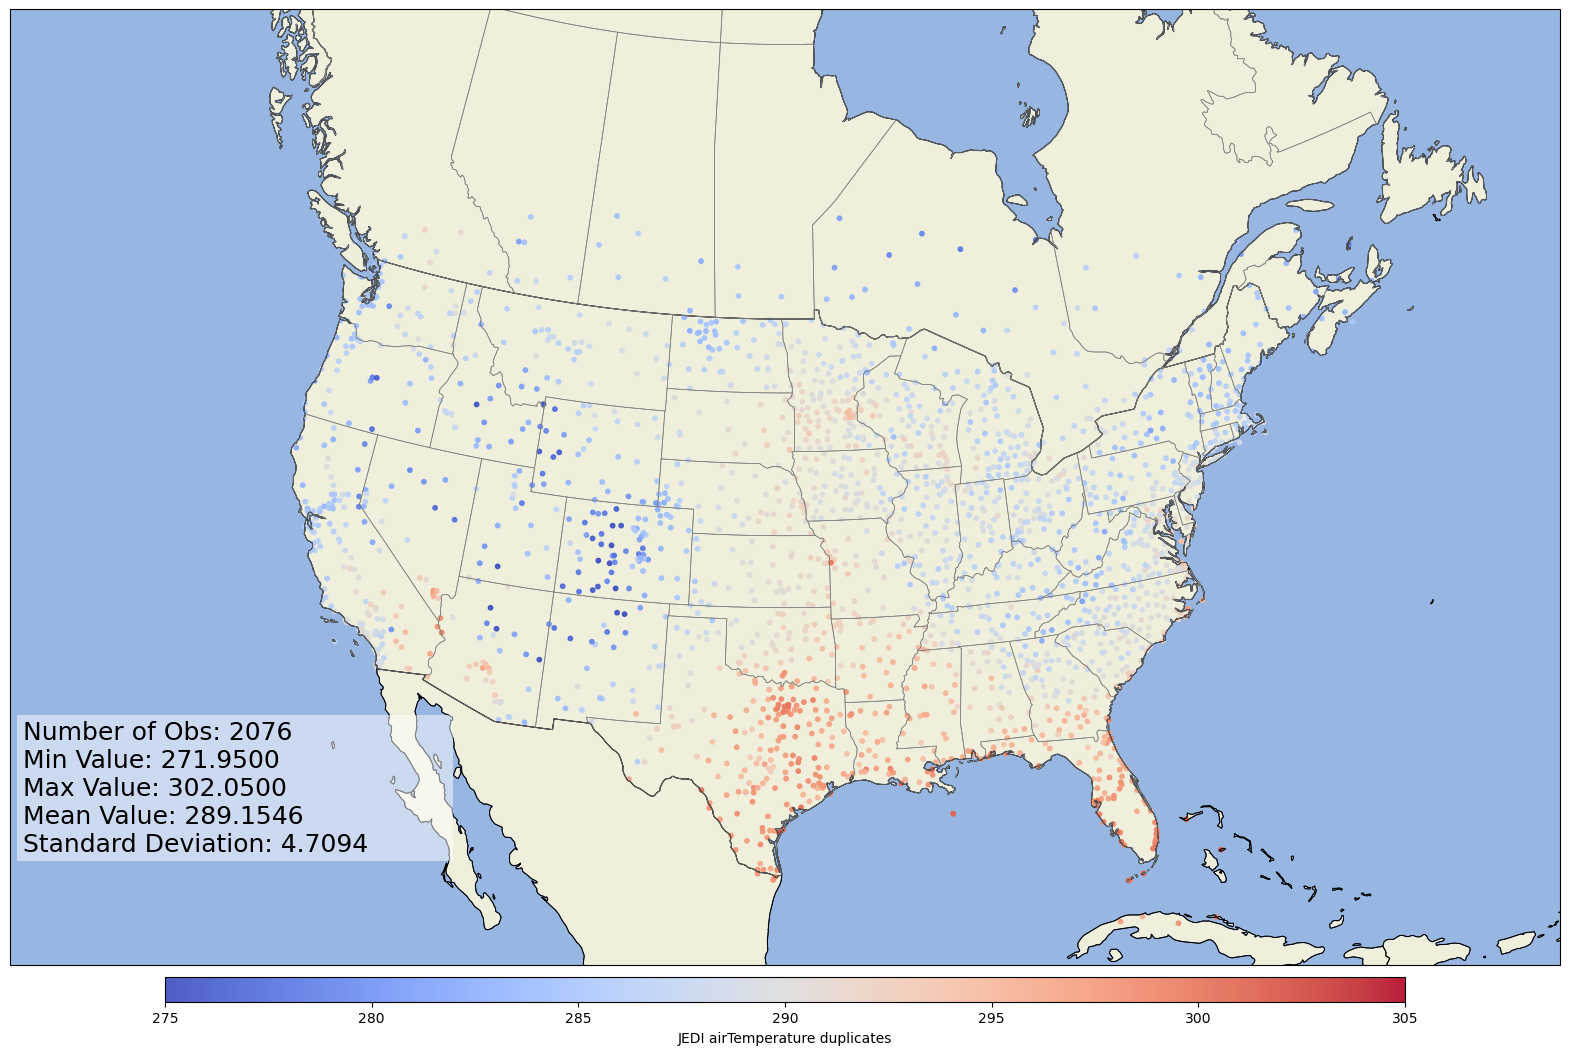

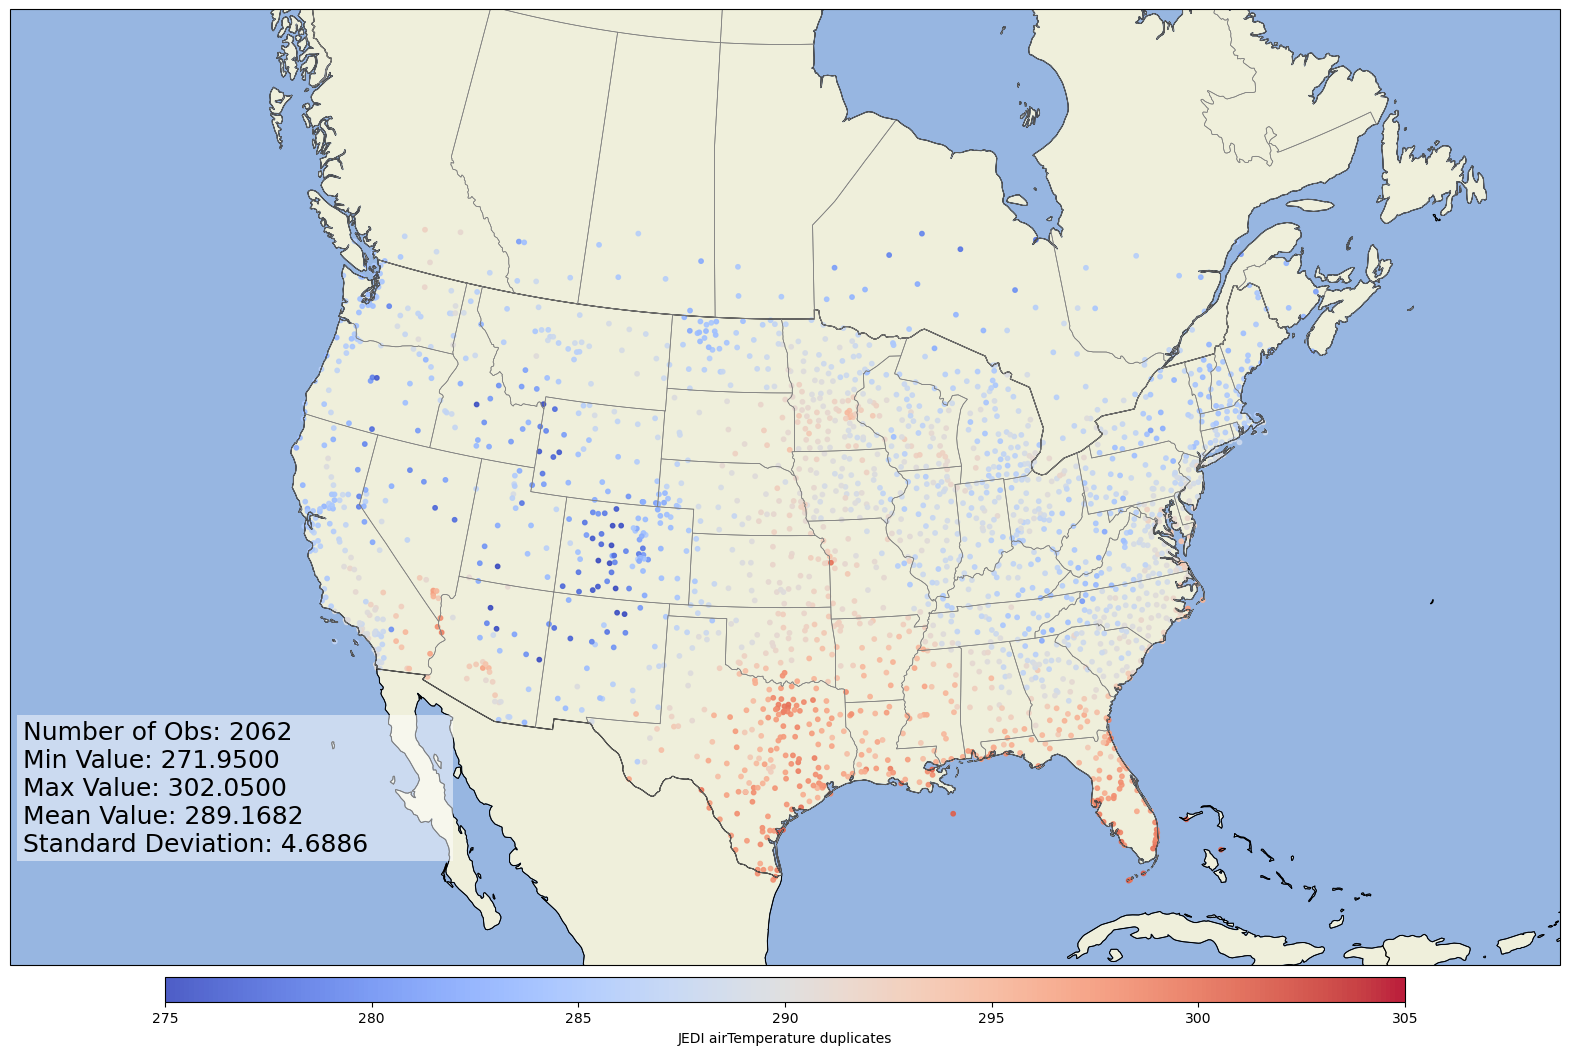

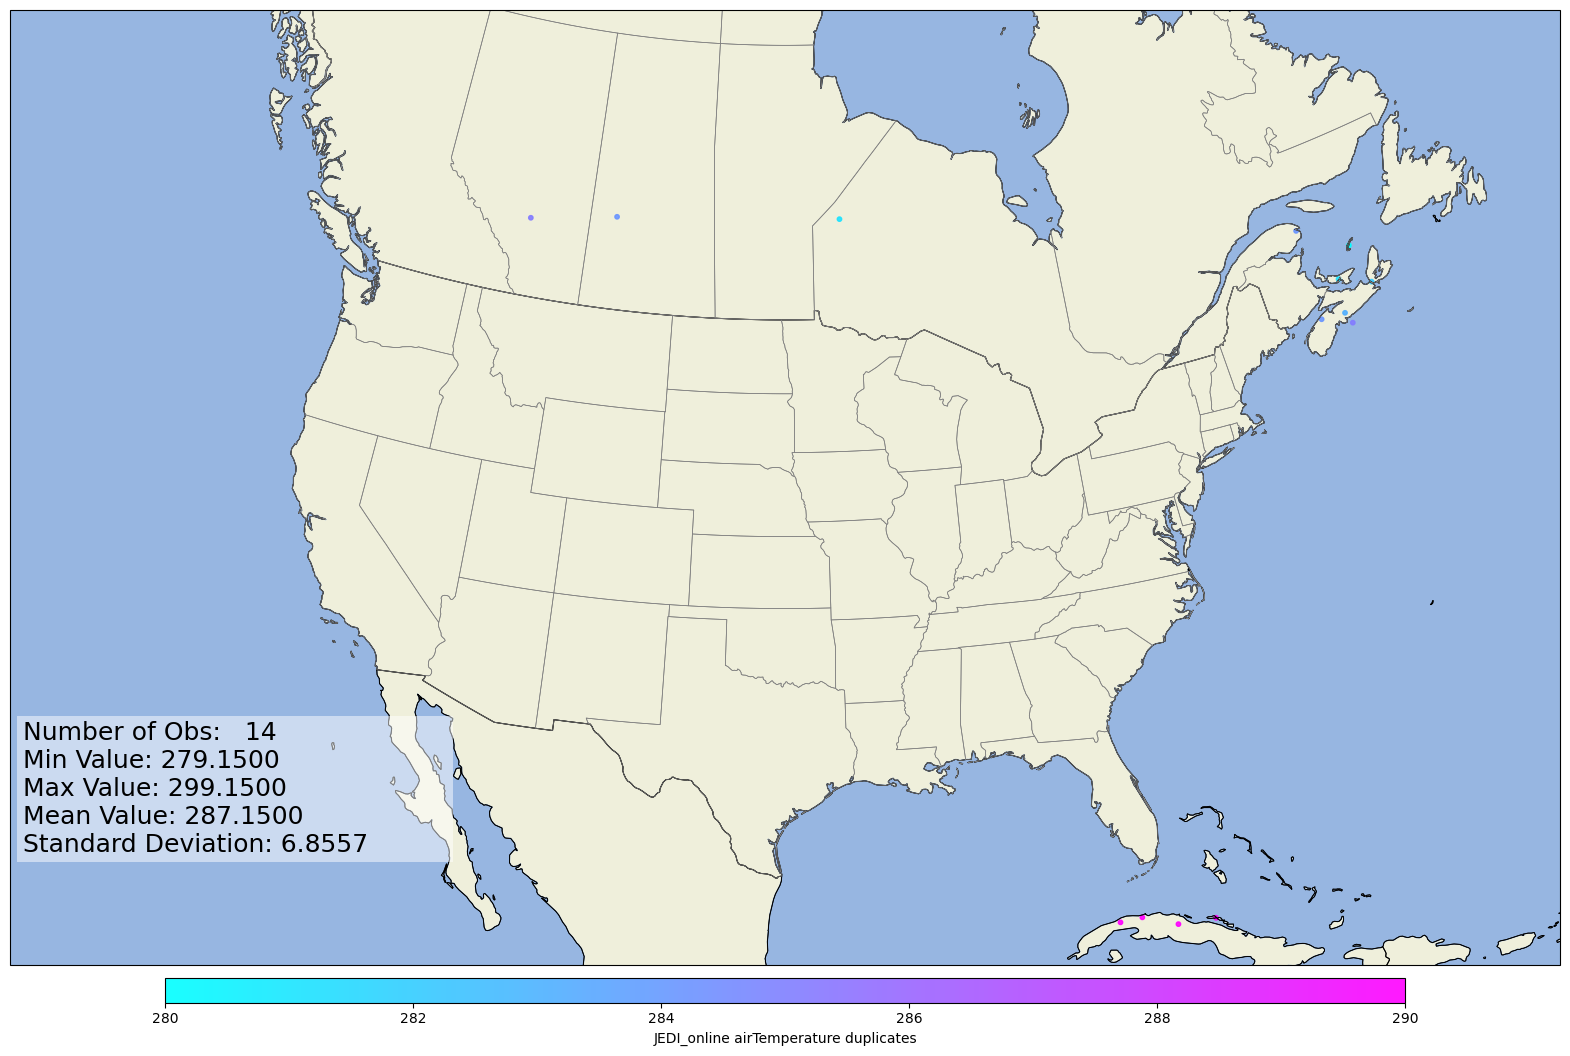

In [10]:
if __name__ == "__main__":
    
    maxlat = 58
    minlat = 22
    maxlon = -63
    minlon = -131
    maxval = 3
    minval = -3

    lats, lons, press, values = read_hofx_file(hofx_dir, hofx_file, group, varname, flag=0)
    data1 = np.column_stack((lats, lons, press, values))
    df1 = pd.DataFrame(data1, columns=['lats', 'lons', 'press', 'values'])
    
    variable_scatter(lons, lats, values, colormap, markersize=10, alpha=0.9, minval=275, maxval=305,
                     area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                     system="JEDI", varname=varname, vartype=group, counts=True)
    
    dup_lats, dup_lons, dup_nums, dup_df = find_duplicates(lats, lons, press, values)
    #dup_df_closest = minimum_calc(dup_df)
    #print(dup_df_closest)
    
    if len(dup_nums) > 0:
        variable_scatter(dup_lons, dup_lats, dup_nums, "cool", markersize=10, alpha=0.9, minval=2,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI", varname=varname, vartype=group, counts=True)
    
    ncol = dup_df.shape[1] - 3
    for icol in range(ncol):
        filtered_df = dup_df[~dup_df[icol].isna()]
        lons = filtered_df["lons"].to_numpy()
        lats = filtered_df["lats"].to_numpy()
        vals = filtered_df[icol].to_numpy()
        variable_scatter(lons, lats, vals, colormap, markersize=10, alpha=0.9, minval=275, maxval=305,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI", varname=varname, vartype=group)

    lats, lons, press, values = read_hofx_file(hofx_dir, hofx_file2, group, varname, flag=0)
    data2 = np.column_stack((lats, lons, press, values))
    df2 = pd.DataFrame(data2, columns=['lats', 'lons', 'press', 'values'])
    variable_scatter(lons, lats, values, colormap, markersize=10, alpha=0.9, minval=275, maxval=305,
                     area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                     system="JEDI", varname=varname, vartype=group, counts=True)
    
    dup_lats, dup_lons, dup_nums, dup_df = find_duplicates(lats, lons, press, values)
    #dup_df_closest = minimum_calc(dup_df)
    #print(dup_df_closest)

    if len(dup_nums) > 0:
        variable_scatter(dup_lons, dup_lats, dup_nums, colormap, markersize=10, alpha=0.9, minval=275, maxval=305,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI", varname=varname, vartype=group, counts=True)
    
    ncol = dup_df.shape[1] - 3
    for icol in range(ncol):
        filtered_df = dup_df[~dup_df[icol].isna()]
        lons = filtered_df["lons"].to_numpy()
        lats = filtered_df["lats"].to_numpy()
        vals = filtered_df[icol].to_numpy()
        variable_scatter(lons, lats, vals, colormap, markersize=10, alpha=0.9, minval=275, maxval=305,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI", varname=varname, vartype=group)

    df1_diff, df2_diff = find_differences(df1, df2)
    df1_lats, df1_lons, df1_vals = df1_diff["lats"].to_numpy(), df1_diff["lons"].to_numpy(), df1_diff["values"].to_numpy()
    if len(df1_vals) > 0:
        variable_scatter(df1_lons, df1_lats, df1_vals, "cool", markersize=10, alpha=0.9, minval=280, maxval=290,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI_online", varname=varname, vartype=group, counts=True)
    df2_lats, df2_lons, df2_vals = df2_diff["lats"].to_numpy(), df2_diff["lons"].to_numpy(), df2_diff["values"].to_numpy()
    if len(df2_vals) > 0:
        variable_scatter(df2_lons, df2_lats, df2_vals, "cool", markersize=10, alpha=0.9, minval=280, maxval=290,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI_offline", varname=varname, vartype=group, counts=True)